In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys, os
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [3]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")
num_qubit = backend.configuration().n_qubits

In [ ]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

# Circuit

## Experiment Circuit

In [4]:
qubit_list = [0, 1]

In [ ]:
def grover(num_qubits, qubits_list = None, iterations = 1, search_state = None, measure = True):
    from qiskit.circuit import QuantumCircuit
    from qiskit.circuit.library import GroverOperator
    from qiskit.quantum_info import Statevector

    if not search_state:
        search_state = "0" * num_qubits
    elif len(search_state) != num_qubits:
        raise ValueError("Search state length is different from qubits in qubit_layout")

    mark_state = Statevector.from_label(search_state)
    
    # specify the Grover operator
    grover_op = GroverOperator(mark_state, insert_barriers=True).decompose()

    # create the Grover's search circuit
    qc = QuantumCircuit(num_qubits, num_qubits)
    # initialize the states
    qc.h(qubits_list)
    # apply the Grover operator `iterations` times
    for _ in range(iterations):
        qc.append(grover_op.decompose(), qubits_list)
    qc = qc.decompose()
    
    # measure the results
    if measure:
        qc.measure(qubits_list, range(num_qubits))
    
    return qc

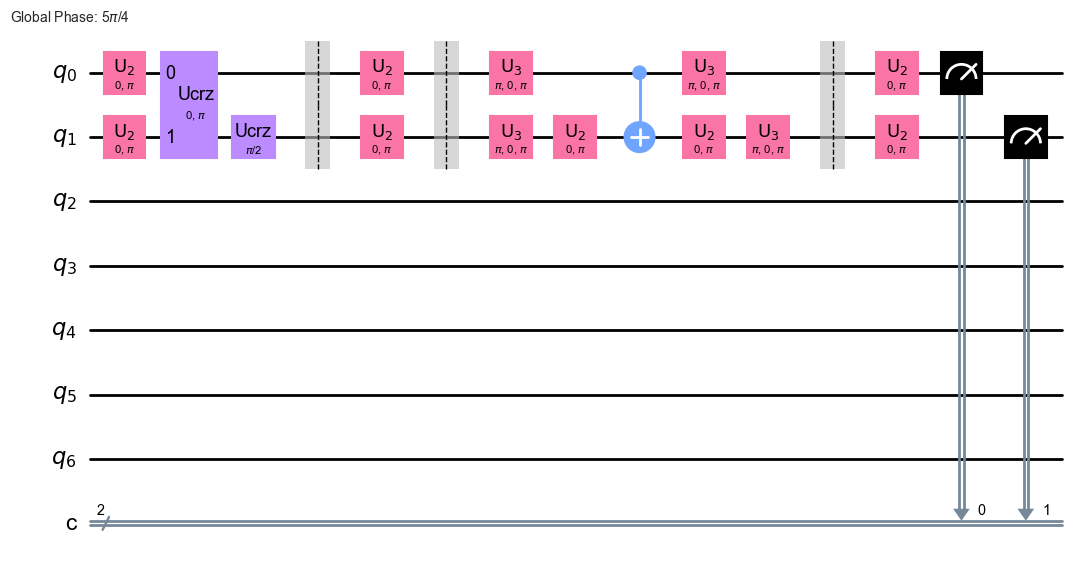

In [5]:
exp_circ = grover(len(qubit_list), qubits_list = qubit_list, iterations = 1, search_state = "11", measure = True)
exp_circ = transpile(exp_circ, backend = backend)
exp_circ.draw()

## Auxiliary Circuits

In [6]:
delay_at_the_end = 1000000

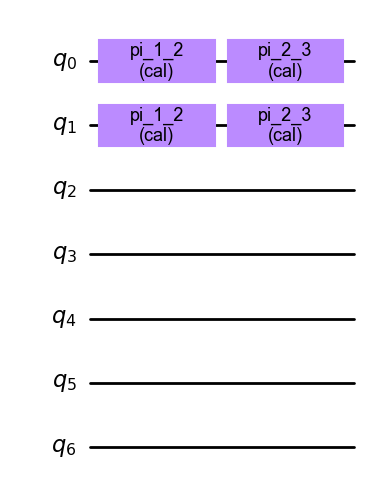

In [7]:
drive_circ = QuantumCircuit(num_qubit)
drive_circ.x(qubit_list)
drive_circ = drive_circ.compose(gen_circ(state = 3, num_qubit = num_qubit, qubit_list = qubit_list, sched = sched, measure = False))
drive_circ = transpile(drive_circ, backend = backend)

drive_circ.draw()

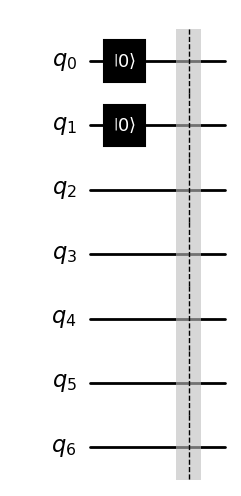

In [8]:
reset_circ = QuantumCircuit(num_qubit)
reset_circ.reset(qubit_list)
reset_circ.barrier()

reset_circ.draw()

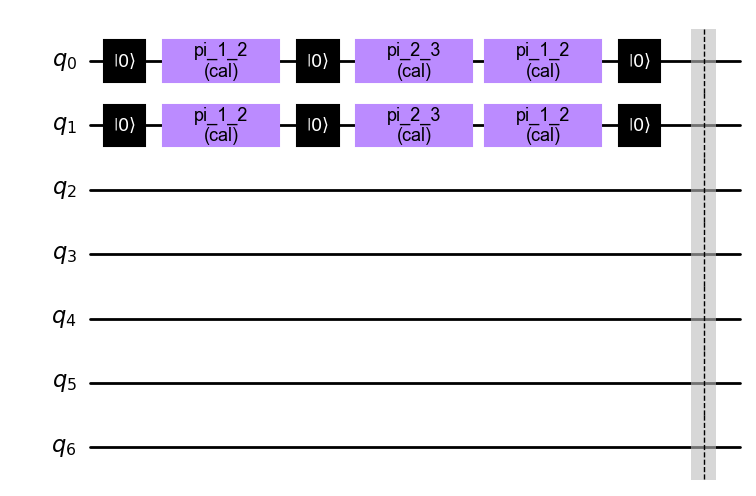

In [9]:
csr_circ = gen_circ(state = 0, num_qubit = num_qubit, qubit_list = qubit_list, sched = sched, num_reset = 1, add_secure_reset = True, measure = False)
csr_circ.barrier()

csr_circ.draw()

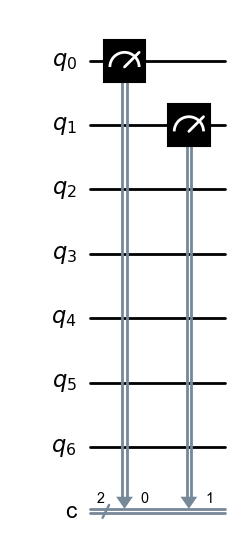

In [10]:
measure_circ = QuantumCircuit(num_qubit, len(qubit_list))
measure_circ.measure(qubit_list, range(len(qubit_list)))

measure_circ.draw()

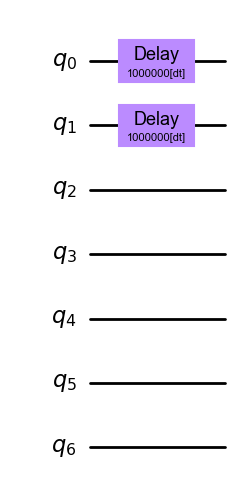

In [11]:
delay_circ = QuantumCircuit(num_qubit)
delay_circ.delay(delay_at_the_end , qubit_list)

delay_circ.draw()

# No Drive at the End

In [12]:
exp_circ = transpile(exp_circ, backend = backend)
exp_circ_list = [
    [exp_circ, measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(reset_circ), measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(csr_circ), measure_circ.compose(delay_circ)]
]
exp_circ_list = [transpile(exp_circs, backend) for exp_circs in exp_circ_list]

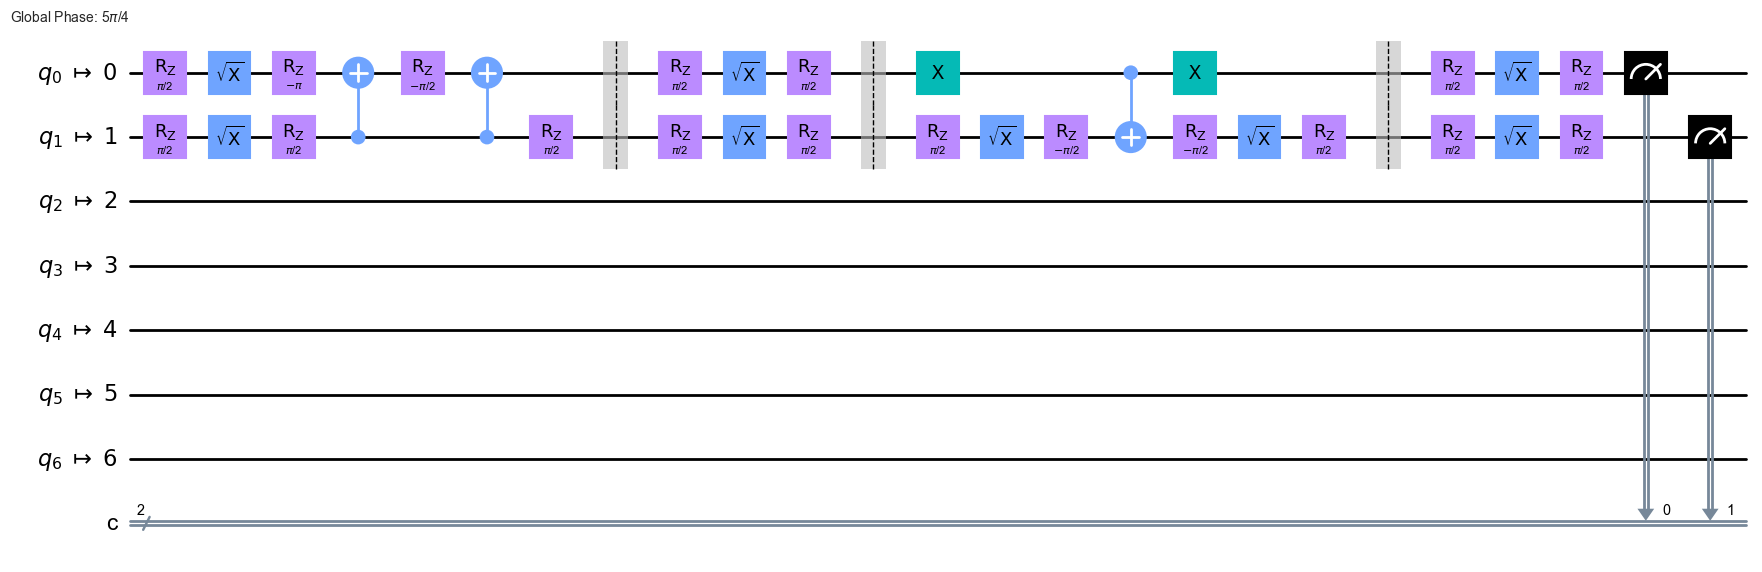

In [13]:
exp_circ_list[0][0].draw()

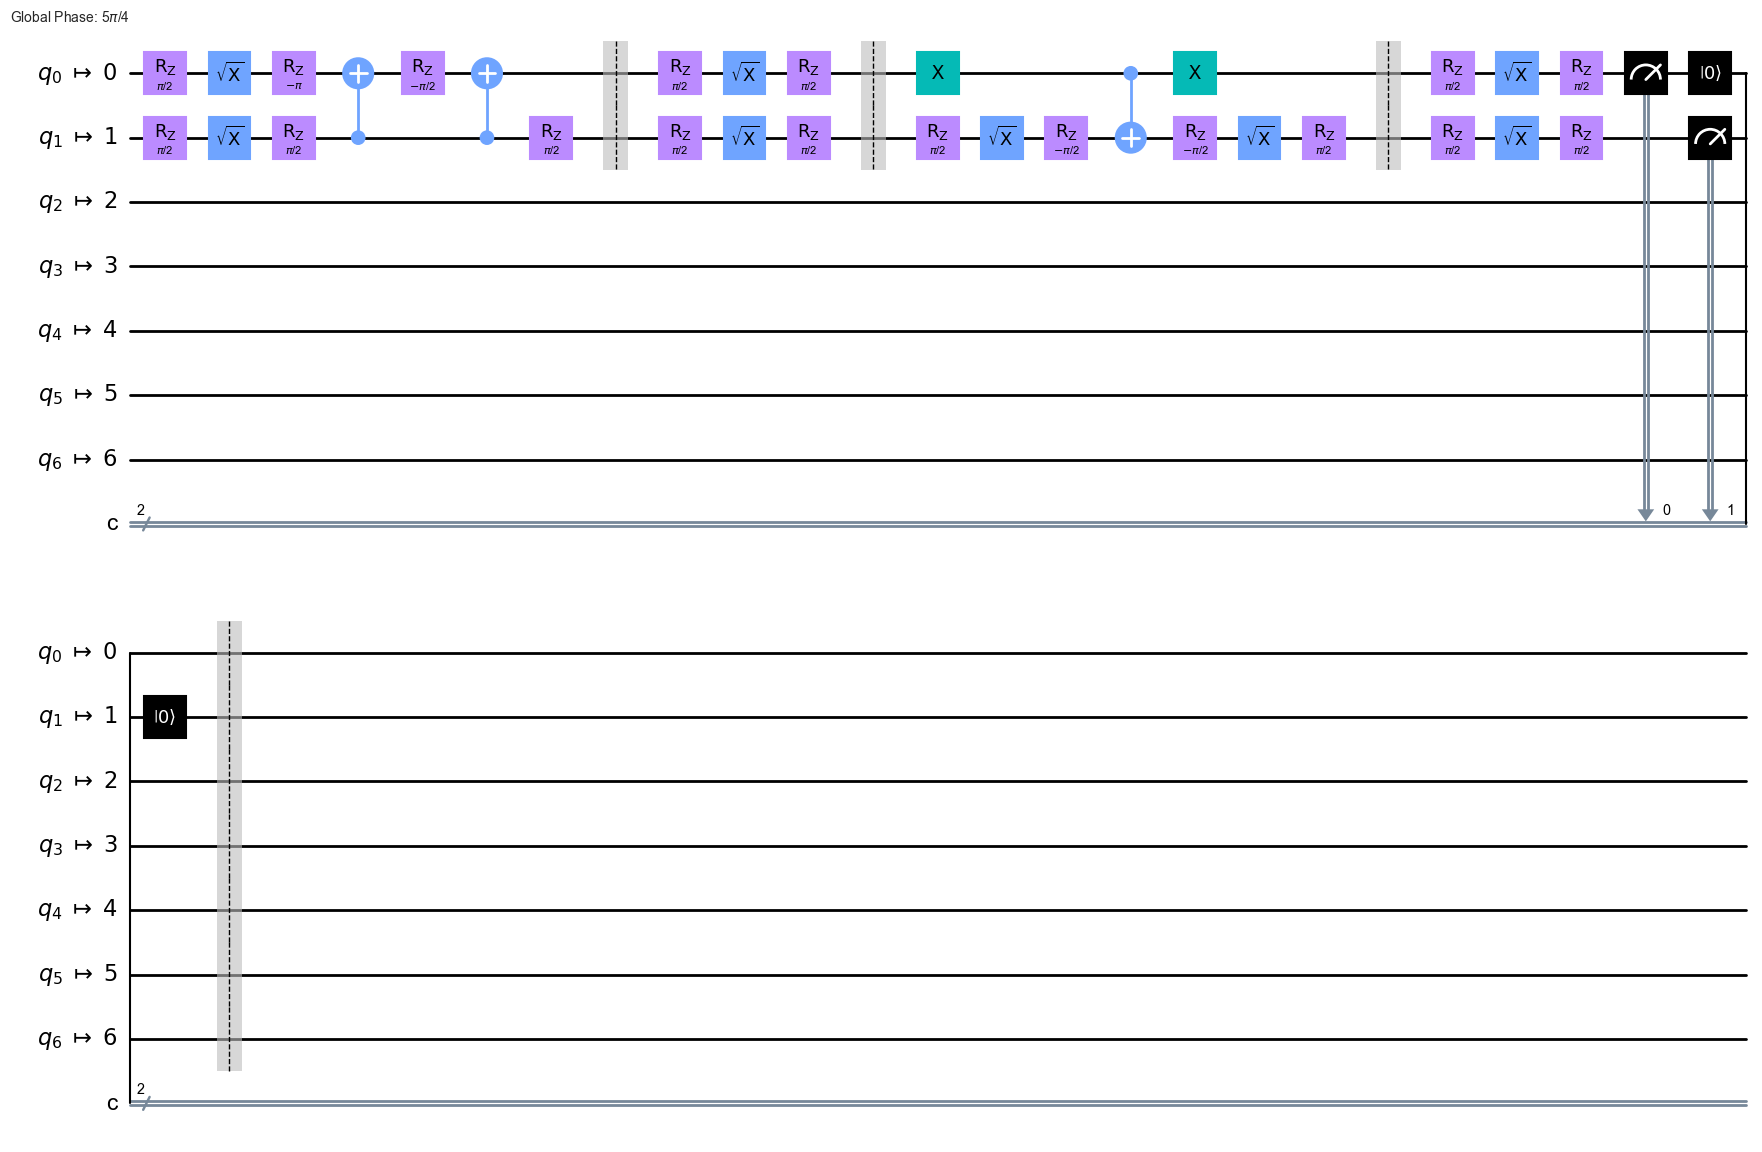

In [14]:
exp_circ_list[1][0].draw()

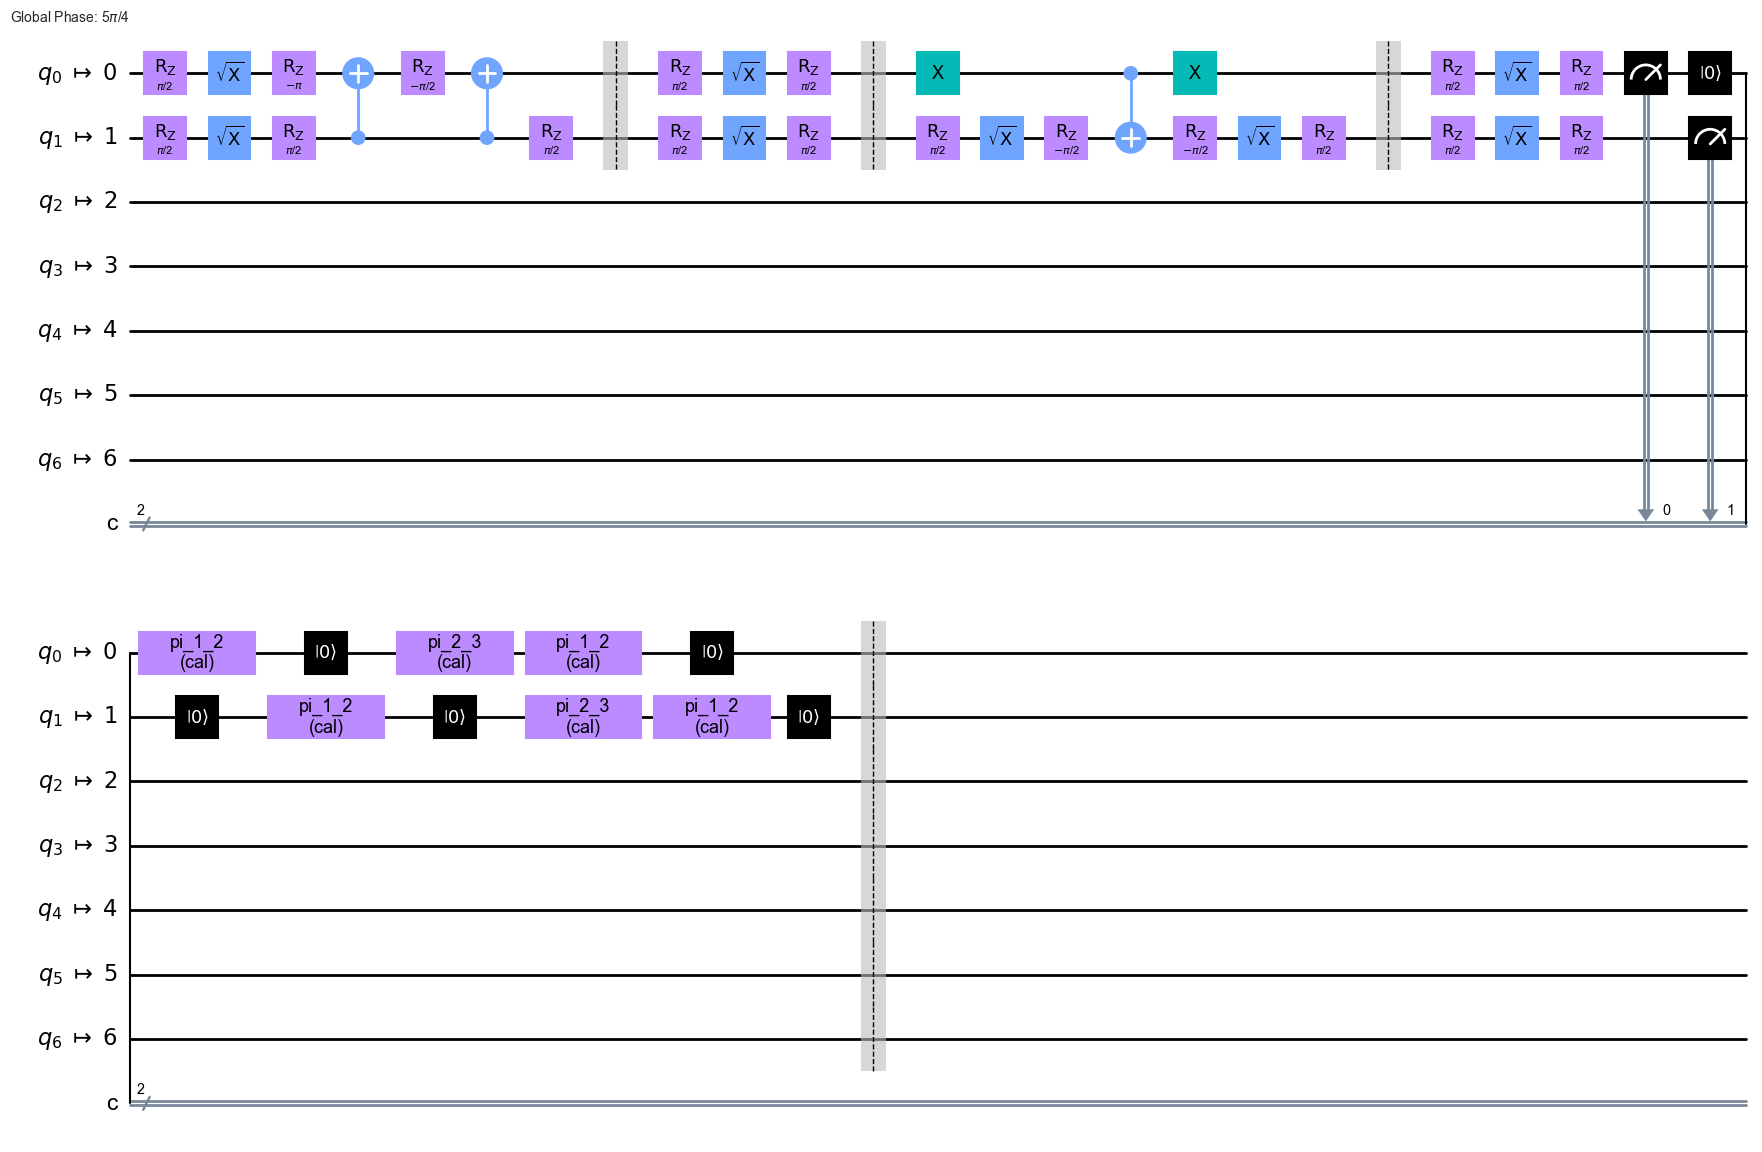

In [15]:
exp_circ_list[2][0].draw()

## Submit

In [41]:
shots = 1000

In [17]:
# job_id_list = []

# job = backend.run(exp_circ_list[0], shots=shots)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[1], shots=shots, rep_delay=0, init_qubits=False)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[2], shots=shots, rep_delay=0, init_qubits=False)
# job_id_list.append(job.job_id())

# job_id_list

['640813d2e023ea1c1bf3e32b',
 '640813d43994601337f133a6',
 '640813d61759863cf19799a0']

In [17]:
# job_no_drive_id_list = ['6407f8eba66286f68f668e55',
#  '6407f8ec9602af3345021a75',
#  '6407f8ee399460d05af1330b']

In [18]:
# job_no_drive_list = [backend.retrieve_job(job_id) for job_id in job_no_drive_id_list]

In [ ]:
# save_job(job_no_drive_list, "data/state_sensing_no_drive.pickle")

In [ ]:
# job_no_drive_list = load_job("data/state_sensing_no_drive.pickle")

# Drive Qubits at the End

In [20]:
exp_circ = transpile(exp_circ, backend = backend)
exp_circ_list = [
    [exp_circ.copy().compose(drive_circ), measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(drive_circ).compose(reset_circ), measure_circ.compose(delay_circ)],
    [exp_circ.copy().compose(drive_circ).compose(csr_circ), measure_circ.compose(delay_circ)]
]
exp_circ_list = [transpile(exp_circs, backend) for exp_circs in exp_circ_list]

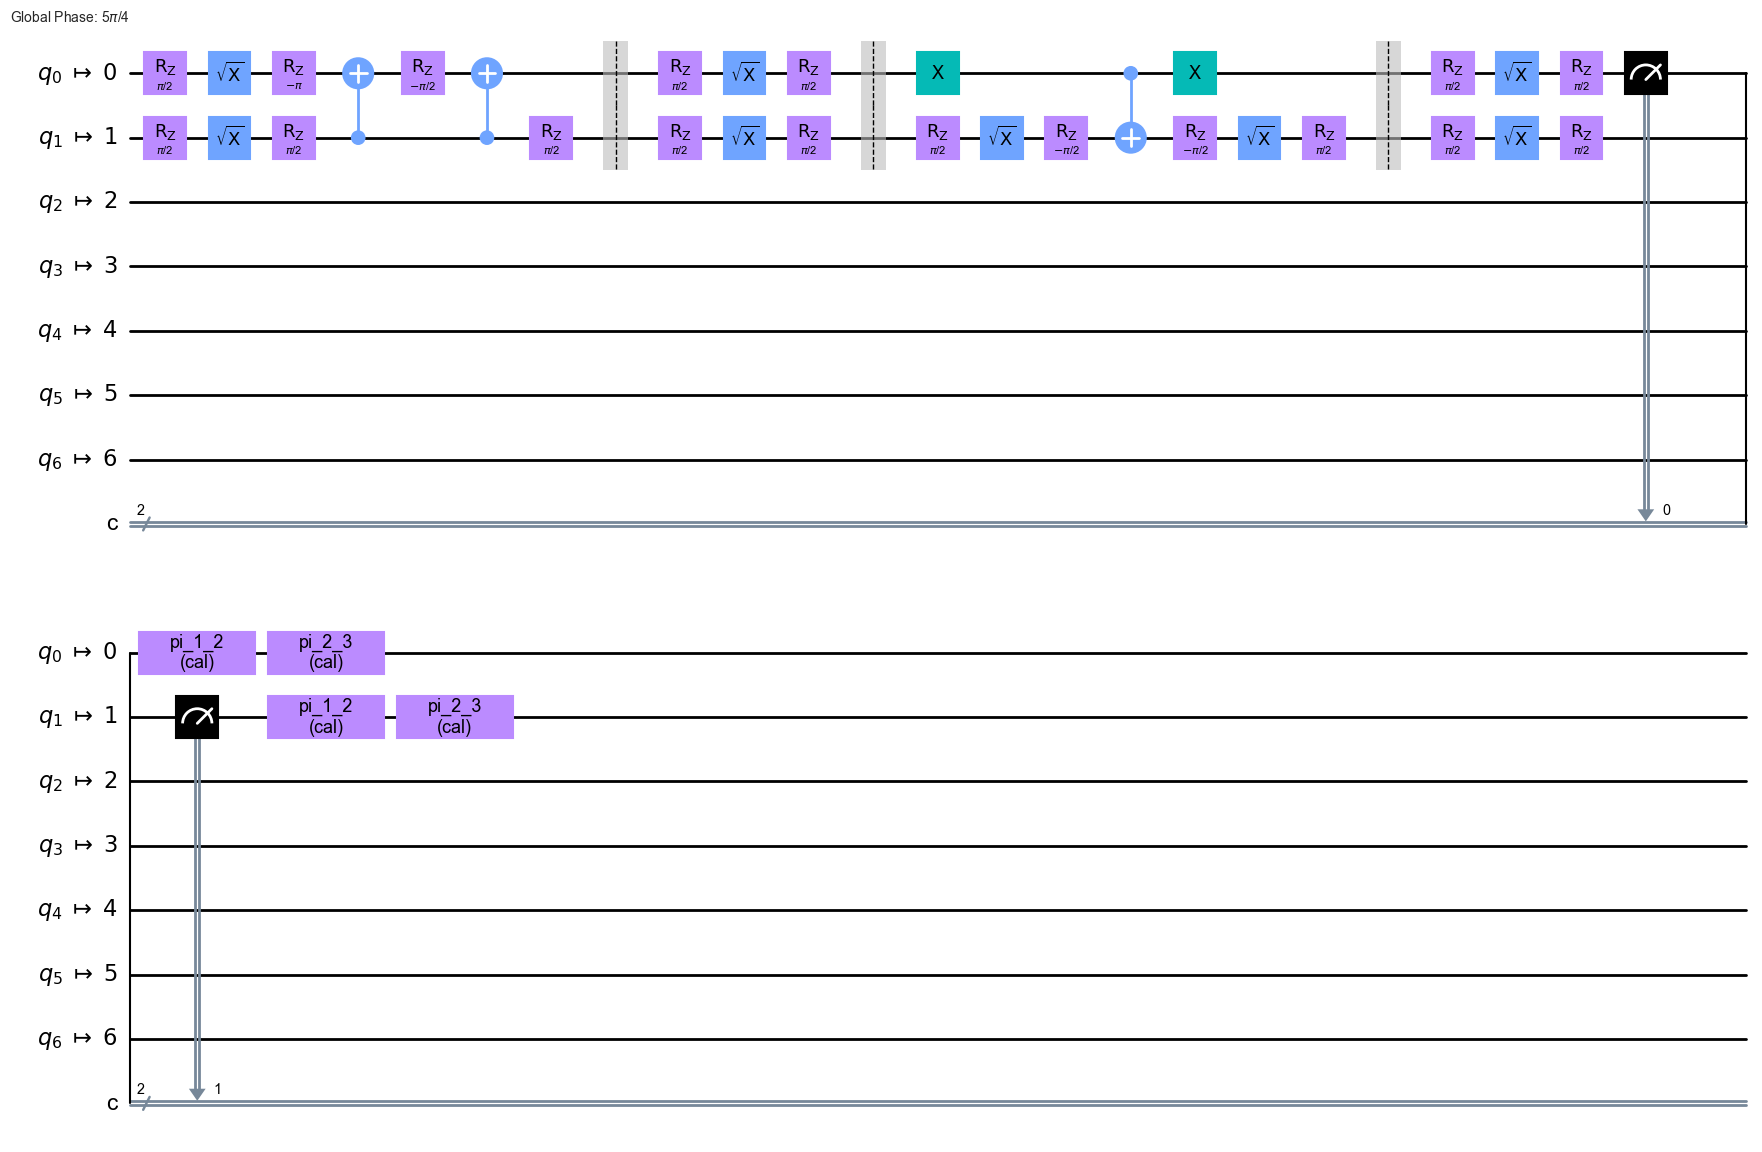

In [21]:
exp_circ_list[0][0].draw()

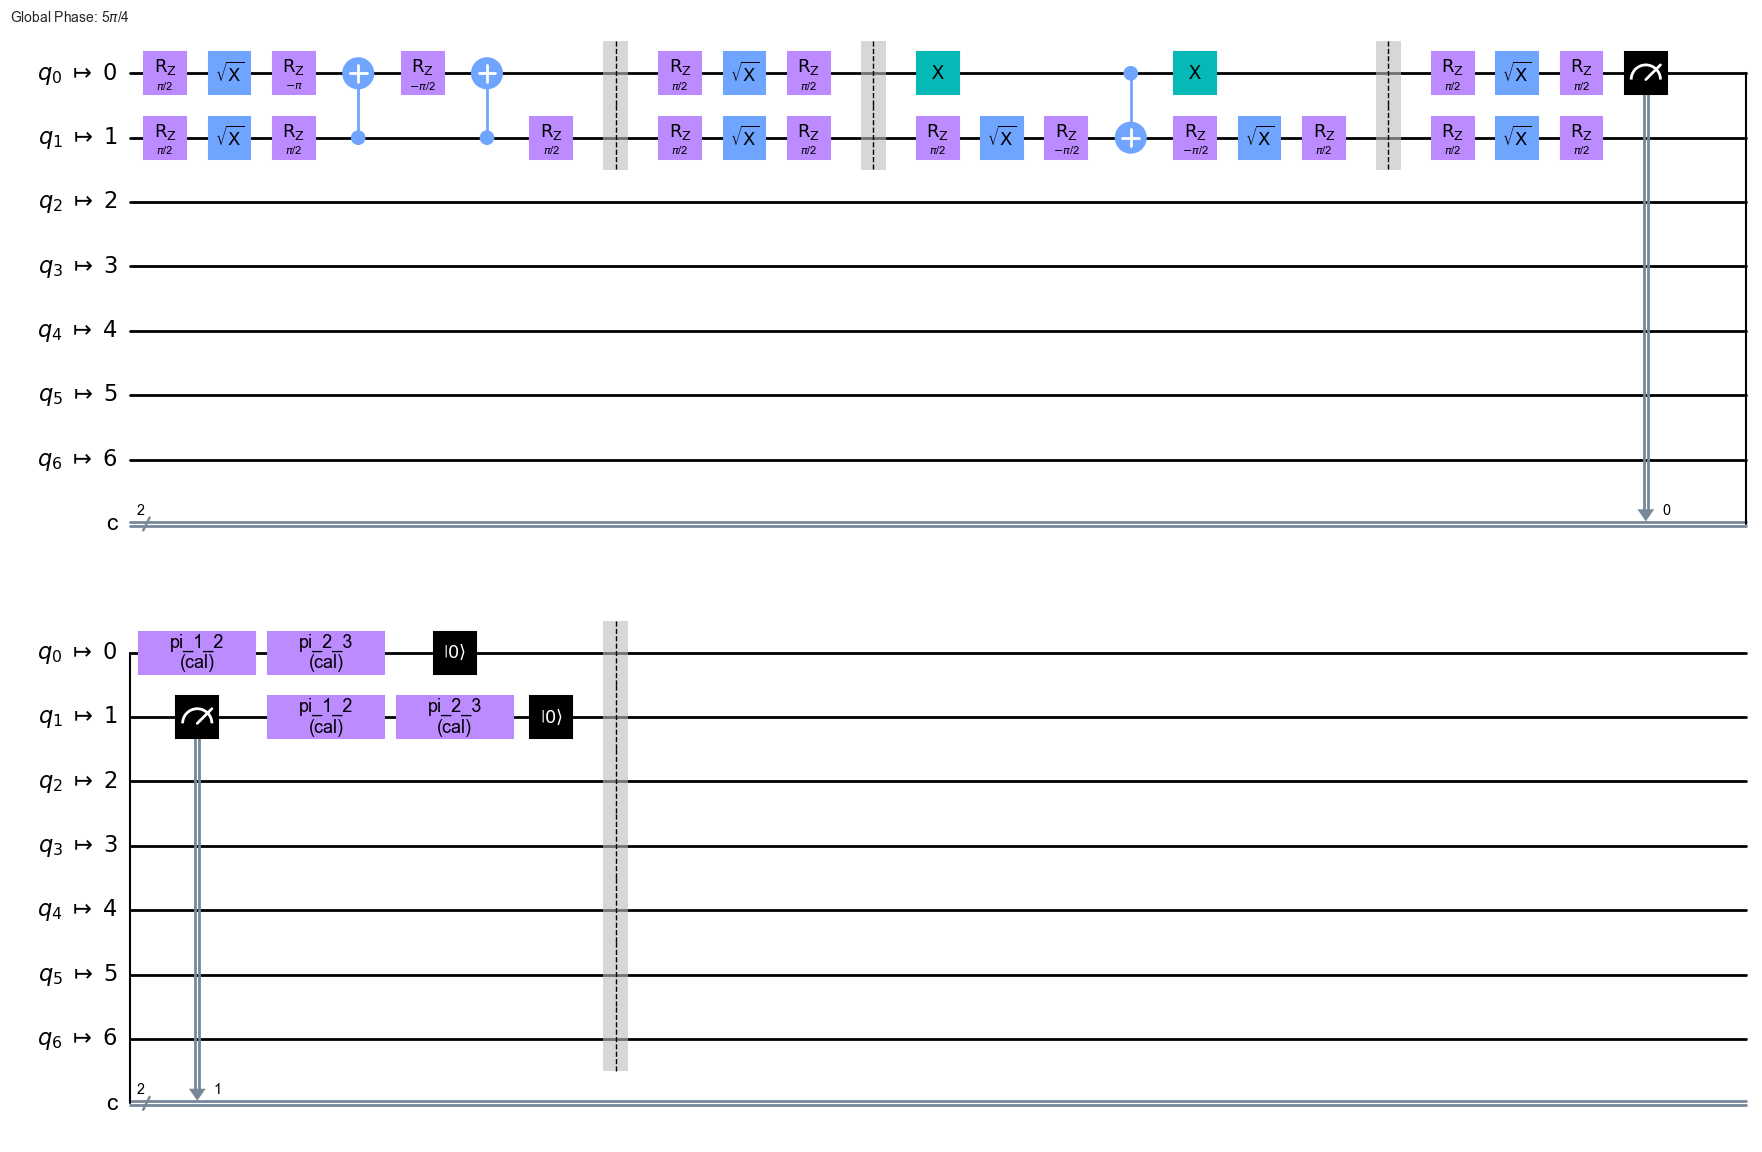

In [22]:
exp_circ_list[1][0].draw()

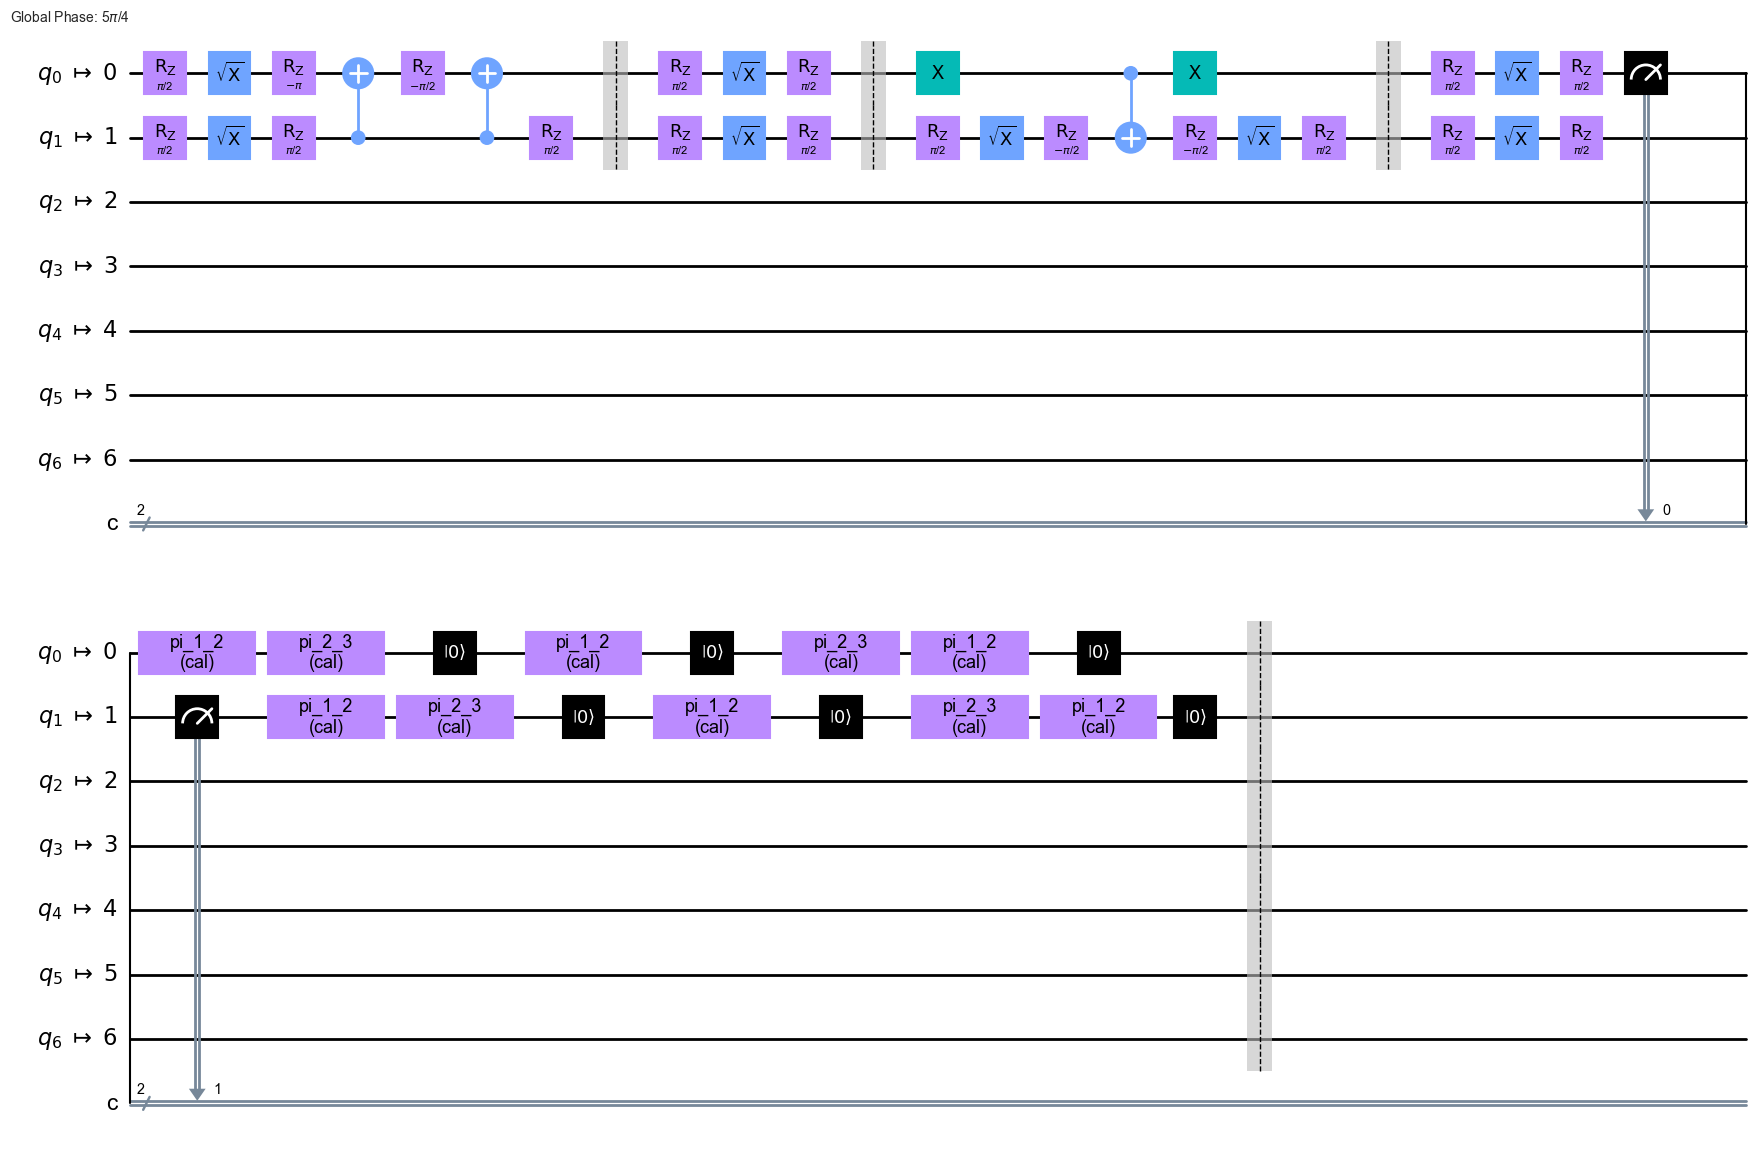

In [23]:
exp_circ_list[2][0].draw()

## Submit

In [24]:
shots = 1000

In [25]:
# job_id_list = []

# job = backend.run(exp_circ_list[0], shots=shots)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[1], shots=shots, rep_delay=0, init_qubits=False)
# job_id_list.append(job.job_id())

# job = backend.run(exp_circ_list[2], shots=shots, rep_delay=0, init_qubits=False)
# job_id_list.append(job.job_id())

# job_id_list

['6408140d52335e4076e0d62c',
 '6408140fbd6bd998950b75aa',
 '6408141052335e5f11e0d62d']

In [26]:
# job_drive_id_list = ['6407f7af5d83d89fe1c752f9',
#  '6407f7b1a66286528e668e4c',
#  '6407f7b25d83d8b051c752fa']

In [27]:
# job_drive_list = [backend.retrieve_job(job_id) for job_id in job_drive_id_list]

In [ ]:
# save_job(job_drive_list, "data/state_sensing_drive.pickle")

In [ ]:
# job_drive_list = load_job("data/state_sensing_drive.pickle")

# Plot

In [ ]:
# job_no_drive_data = [job_no_drive_list[i].result().get_counts() for i in range(3)]
# save_job(job_no_drive_data, "data/state_sensing_no_drive_data.pickle")
# job_drive_data = [job_drive_list[i].result().get_counts() for i in range(3)]
# save_job(job_drive_data, "data/state_sensing_drive_data.pickle")

In [ ]:
job_no_drive_data = load_job("data/state_sensing_no_drive_data.pickle")
job_drive_data = load_job("data/state_sensing_drive_data.pickle")

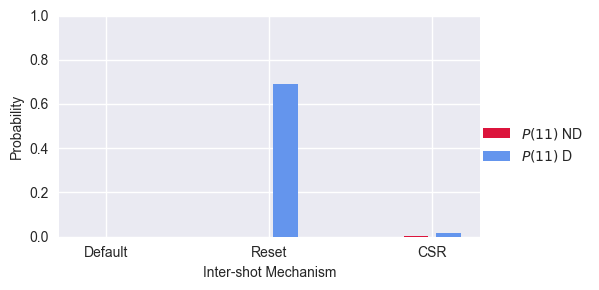

In [49]:
# creating the dataset
fig = plt.figure(figsize = (5, 3), dpi = 100)

width = 1.0
bar_width = 0.15
bar_hatch = 0.3

# creating the bar plot
for i, mechanism in enumerate(["Default", "Reset", "CSR"]):
    x = np.array([-0.1, 0.1]) + i * width
    try:
        plt.bar(x[0], job_no_drive_data[i][1]['11'] / shots, color = 'crimson', width = bar_width)
    except KeyError:
        plt.bar(x[0], 0, color = 'cornflowerblue', alpha = bar_hatch, width = bar_width)
    try:
        plt.bar(x[1], job_drive_data[i][1]['11'] / shots, color = 'cornflowerblue', width = bar_width)
    except KeyError:
        plt.bar(x[1], 0, color = 'cornflowerblue', width = bar_width)


plt.xlabel("Inter-shot Mechanism")
plt.xticks(np.array([0, width, 2 * width]), ["Default", "Reset", "CSR"])
plt.ylabel("Probability")
plt.ylim((0, 1.0))


from matplotlib.patches import Rectangle
handles = [
    Rectangle((0, 0), 1, 0.8, label=r"$P(11)$ ND", facecolor = 'crimson'),
    Rectangle((0, 0), 1, 0.8, label=r"$P(11)$ D", facecolor = 'cornflowerblue'),
]
fig.legend(handles=handles, fontsize=10, loc='center left', bbox_to_anchor=(0.95, 0.5))

plt.tight_layout()

# plt.savefig("./figs/trojan_grover.pdf", bbox_inches = "tight")